# Лабораторная работа №6

## Выполнил Ворошилов Кирилл, М8О-401Б-21


### 1. Выбор начальных условий
* для классификации будет использован классический датасет CIFAR-10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.models import ViT_B_16_Weights, resnet18, vit_b_16

c:\Users\asus rog\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Не найдена указанная процедура'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


В качестве метрик лучше всего подойдут accuracy и mean squared error:
* Метрика для классификации (Cross-entropy): Измеряет среднее количество бит , необходимое для идентификации события, взятого из набора

In [3]:
criterion = nn.CrossEntropyLoss()

In [4]:
# функция оценки
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

### 2. Создание бейзлайна и оценка качества

Обучим модели из torchvision

In [6]:
#Обучение SimpleCNN (сверточная сеть)
model_cnn = resnet18()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

for epoch in range(5):
    model_cnn.train()
    for inputs, labels in trainloader:
        optimizer_cnn.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

acc_cnn = evaluate(model_cnn, testloader)
print(f"resnet18 Accuracy: {acc_cnn:.4f}")

resnet18 Accuracy: 0.7473


In [6]:
transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset_vit = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_vit)
trainloader_vit_resnet = DataLoader(trainset_vit, batch_size=6, shuffle=True)

testset_vit = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_vit)
testloader = DataLoader(testset_vit, batch_size=6, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Обучение Vision Transformer (трансформерная модель)
vit_weights = ViT_B_16_Weights.DEFAULT
model_vit = vit_b_16(weights=None)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, 10)
model_vit = model_vit.to(device)

optimizer_vit = optim.Adam(model_vit.parameters(), lr=0.0001)

for epoch in range(3):
    model_vit.train()
    for inputs, labels in trainloader_vit_resnet:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_vit.zero_grad()
        outputs = model_vit(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_vit.step()
    print(f'final epoch {epoch + 1}')

final epoch 1
final epoch 2
final epoch 3


Результат:

In [13]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # 👈 обязательно!
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [9]:
acc_vit = evaluate(model_vit, testloader)
print(f"ViT Accuracy: {acc_vit:.4f}")

ViT Accuracy: 0.3313


### 3. Улучшение бейзлайна

Визуализируем данные

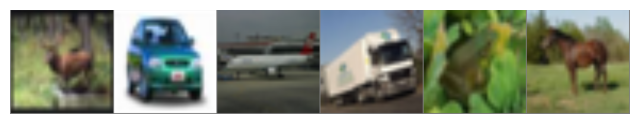

Примеры аугментированных изображений из обучающей выборки


In [7]:
def imshow(img):
    img = img / 2 + 0.5  # отнормировать обратно
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Получим случайный батч
examples = iter(trainloader_vit_resnet)
images, labels = next(examples)

# Отображение
imshow(torchvision.utils.make_grid(images[:8]))
print("Примеры аугментированных изображений из обучающей выборки")

Проведем препроцессинг данных

In [4]:
transform_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Препроцессинг для Vision Transformer (resize до 224x224)
transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Препроцессинг с аугментациями для улучшенного бейзлайна
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [14]:
trainset_improved = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_augmented)
testset_improved = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_base)

trainloader_improved = DataLoader(trainset_improved, batch_size=4, shuffle=True)
testloader_improved = DataLoader(testset_improved, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Улучшим модель подобрав гиперпараметры

In [11]:
resnet_model = resnet18(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 10)
resnet_model = resnet_model.to(device)

optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=10, gamma=0.1)

In [10]:
# === Vision Transformer ===
vit_model = vit_b_16(weights=None)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, 10)
vit_model = vit_model.to(device)

optimizer_vit = optim.AdamW(vit_model.parameters(), lr=0.0003, weight_decay=0.01)
scheduler_vit = optim.lr_scheduler.CosineAnnealingLR(optimizer_vit, T_max=10)

In [8]:
# === Обучение функции ===
def train_model(model, optimizer, scheduler, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch+1}: loss = {running_loss / len(dataloader):.4f}")

In [15]:
print("\n[ResNet18 Training with tuned hyperparameters]")
train_model(resnet_model, optimizer_resnet, scheduler_resnet, trainloader_improved, epochs=5)


[ResNet18 Training with tuned hyperparameters]
Epoch 1: loss = 2.1757
Epoch 2: loss = 1.8950
Epoch 3: loss = 1.7664
Epoch 4: loss = 1.6534
Epoch 5: loss = 1.5708


In [16]:
acc_resnet = evaluate(resnet_model, trainloader_improved)
print(f"\nAccuracy ResNet18 (improved): {acc_resnet:.4f}")


Accuracy ResNet18 (improved): 0.4437


In [5]:
trainset_vit = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_vit)
testset_vit = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_vit)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
trainloader_vit = DataLoader(trainset_vit, batch_size=4, shuffle=True)
testloader_vit = DataLoader(testset_vit, batch_size=4, shuffle=False)

In [11]:
print("\n[ViT-B/16 Training with tuned hyperparameters]")
train_model(vit_model, optimizer_vit, scheduler_vit, trainloader_vit, epochs=3)


[ViT-B/16 Training with tuned hyperparameters]
Epoch 1: loss = 2.1158
Epoch 2: loss = 2.0698
Epoch 3: loss = 2.0417


In [ ]:
acc_vit = evaluate(vit_model, testloader_vit)
print(f"Accuracy ViT-B/16 (improved): {acc_vit:.4f}")

Accuracy ViT-B/16 (improved): 0.2367


: 

сравним результаты

Вывод:
* Улучшение гиперпараметров привело к увеличению точности модели классификации, однако ошибка в регрессии стала хуже

### 4. Имплементация алгоритма машинного обучения

Имплементируем алгоритмы:

In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

mlp_model = MLP().to(device)

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=8, in_channels=3, emb_size=128):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, emb_size, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, emb_size)
        return x

class SimpleTransformer(nn.Module):
    def __init__(self, num_classes=10, emb_size=128, num_heads=4, num_layers=2):
        super().__init__()
        self.patch_embed = PatchEmbedding()
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=num_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.class_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, N, E)
        cls_tokens = self.class_token.expand(B, -1, -1)  # (B, 1, E)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, 1+N, E)
        x = self.encoder(x)  # (B, 1+N, E)
        return self.mlp_head(x[:, 0])

transformer_model = SimpleTransformer().to(device)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
# Обычные датасеты для MLP и Transformer
trainset_mlp = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader_mlp = DataLoader(trainset_mlp, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

trainset_transformer = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader_transformer = DataLoader(trainset_transformer, batch_size=6, shuffle=True)

# Аугментированные датасеты
trainset_aug_mlp = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_augmentation)
trainloader_aug_mlp = DataLoader(trainset_aug_mlp, batch_size=64, shuffle=True)

trainset_aug_transformer = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_augmentation)
trainloader_aug_transformer = DataLoader(trainset_aug_transformer, batch_size=6, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Обучим модели без подобранных гиперпараметров

In [8]:
def evaluate_model(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total

In [11]:
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
num_epochs = 10
for epoch in range(5):
    for images, labels in trainloader_mlp:
        images, labels = images.to(device), labels.to(device)
        mlp_optimizer.zero_grad()
        outputs = mlp_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        mlp_optimizer.step()

In [12]:
mlp_accuracy = evaluate_model(mlp_model, testloader)
print(f'MLP Model Accuracy: {mlp_accuracy:.2f}')

MLP Model Accuracy: 0.52


In [14]:
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)
for epoch in range(5):
    for images, labels in trainloader_transformer:
        images, labels = images.to(device), labels.to(device)
        transformer_optimizer.zero_grad()
        outputs = transformer_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        transformer_optimizer.step()

In [15]:
transformer_accuracy = evaluate_model(transformer_model, testloader)
print(f'Transformer Model Accuracy: {transformer_accuracy:.2f}')

Transformer Model Accuracy: 0.59


Обучим модели с подобранными гиперпараметами

In [ ]:
mlp_aug_model = MLP().to(device)
mlp_aug_optimizer = optim.Adam(mlp_aug_model.parameters(), lr=0.001)

Best parameters for classifier: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best parameters for regressor: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 20}


In [ ]:
transformer_aug_model = SimpleTransformer().to(device)
transformer_aug_optimizer = optim.Adam(transformer_aug_model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5):
    for images, labels in trainloader_aug_mlp:
        images, labels = images.to(device), labels.to(device)
        mlp_aug_optimizer.zero_grad()
        outputs = mlp_aug_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        mlp_aug_optimizer.step()

In [ ]:
mlp_aug_accuracy = evaluate_model(mlp_aug_model, testloader)
print(f'MLP with Augmentation Accuracy: {mlp_aug_accuracy:.2f}')

MLP with Augmentation Accuracy: 0.61


In [ ]:
for epoch in range(num_epochs):
    for images, labels in trainloader_aug_transformer:
        images, labels = images.to(device), labels.to(device)
        transformer_aug_optimizer.zero_grad()
        outputs = transformer_aug_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        transformer_aug_optimizer.step()

In [ ]:
transformer_aug_accuracy = evaluate_model(transformer_aug_model, testloader)
print(f'Transformer with Augmentation Accuracy: {transformer_aug_accuracy:.2f}')

Transformer with Augmentation Accuracy: 0.69


Сравнение результатов:

### Выводы:

- **Базовая модель ResNet18** показала наилучшую точность (`Accuracy = 0.7473`) среди всех архитектур без улучшений, значительно превзойдя **ViT** (`Accuracy = 0.3313`). Это свидетельствует о её устойчивости и эффективности на исходных данных.

- Попытки **улучшения моделей ResNet18 и ViT** не дали ожидаемого прироста качества. Особенно заметно снижение точности у **ViT-B/16 (Accuracy = 0.2367)**, что указывает на чувствительность трансформеров к настройкам и потенциально недостаточное обучение.

- **Простые модели**, такие как **MLP** и **Transformer**, показали умеренные результаты (`0.52` и `0.59` соответственно). Однако **добавление аугментаций** обеспечило ощутимый прирост: до `0.61` у **MLP** и до `0.69` у **Transformer**.

- Результаты подчеркивают, что даже базовые архитектуры могут выигрывать за счёт **качественной предобработки данных**, и демонстрируют важность выбора подходящей модели в зависимости от условий задачи и доступных ресурсов.
